In [10]:
import numpy as np
import pandas as pd
import os
from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import joblib

import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings
from IPython.display import display, HTML
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import shap 
import lime# SHAP for explainability
from lime.lime_tabular import LimeTabularExplainer  # LIME for local explanations
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf





# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt) #ensures any changes made to matplotlib.pyplot during the session are applied.
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

# configure plotly graph objects
pio.renderers.default = 'iframe'
# pio.renderers.default = 'vscode'

pio.templates["ck_template"] = go.layout.Template(
    layout_colorway = px.colors.sequential.Viridis, 
#     layout_hovermode = 'closest',
#     layout_hoverdistance = -1,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font = dict(family="Calibri Light"),
    layout_title_font = dict(family="Calibri"),
    layout_hoverlabel_font = dict(family="Calibri Light"),
#     plot_bgcolor="white",
)
 
# pio.templates.default = 'seaborn+ck_template+gridon'
pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

In [11]:

df = pd.read_csv('dataset/edge_iiot.csv', low_memory=False)

In [12]:
df.shape

(1909671, 69)

In [13]:
df.shape

(1909671, 69)

In [14]:
print(df['Attack_type'].value_counts())

Attack_type
7     1363998
4      121567
2       67939
11      50826
3       50062
13      50026
8       49933
1       48544
12      36807
0       24026
9       19977
14      15066
10       9689
5         853
6         358
Name: count, dtype: int64


In [15]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Extract features and labels
X = df.drop(columns=['Attack_type','Attack_label']).values
y = df['Attack_type'].values

num_clients = 5
alpha = 0.5
classes = np.unique(y)
data_per_client = defaultdict(list)

# Dirichlet-based partitioning
for c in classes:
    idx = np.where(y == c)[0]
    np.random.shuffle(idx)
    proportions = np.random.dirichlet([alpha] * num_clients)
    proportions = (np.cumsum(proportions) * len(idx)).astype(int)[:-1]
    splits = np.split(idx, proportions)
    
    for client_id, data_idx in enumerate(splits):
        data_per_client[client_id].extend(data_idx)

# Build client datasets
client_datasets = {}
for client_id, indices in data_per_client.items():
    client_X = X[indices]
    client_y = y[indices]
    client_datasets[client_id] = (client_X, client_y)

    # Save to CSV
    client_df = pd.DataFrame(client_X, columns=df.drop(columns=['Attack_type','Attack_label']).columns)
    client_df['Attack_type'] = client_y
    client_df['Attack_label'] = df.loc[indices, 'Attack_label'].values
    client_df.to_csv(f'dataset/client_{client_id}_data.csv', index=False)
    print(f"Client {client_id} data saved with {len(client_y)} samples.")


Client 0 data saved with 905558 samples.
Client 1 data saved with 286629 samples.
Client 2 data saved with 117575 samples.
Client 3 data saved with 432194 samples.
Client 4 data saved with 167715 samples.


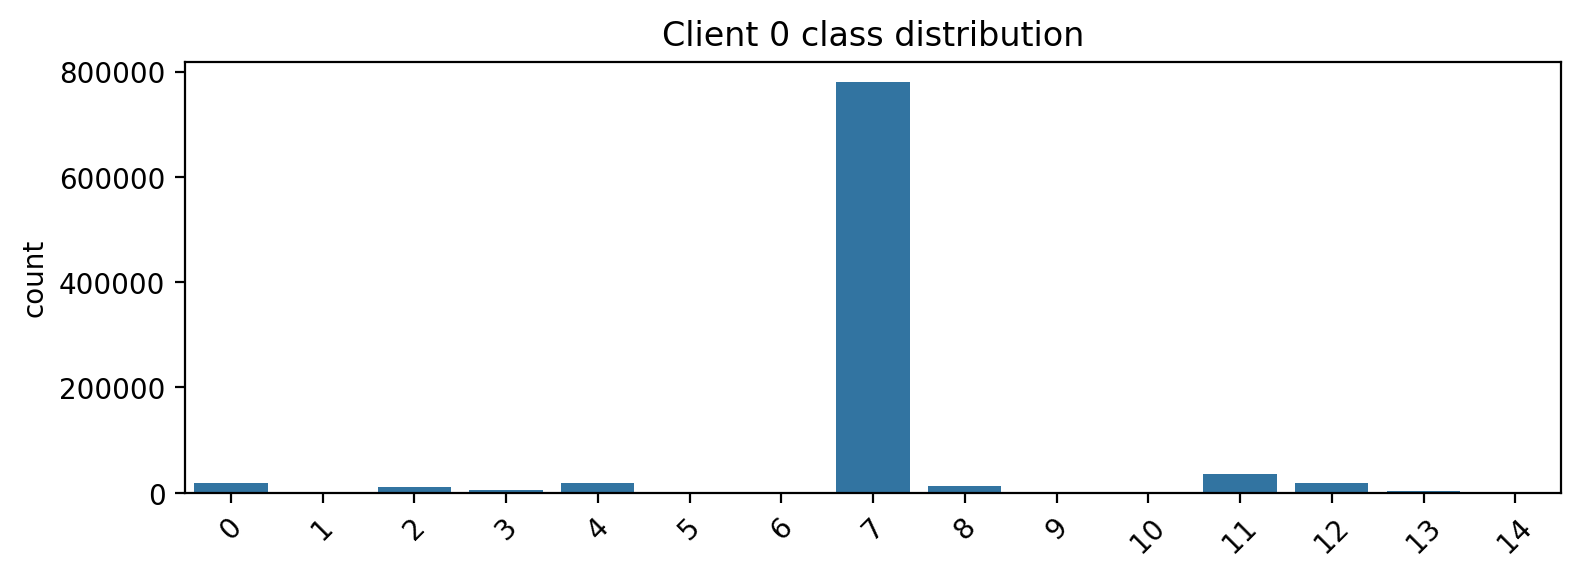

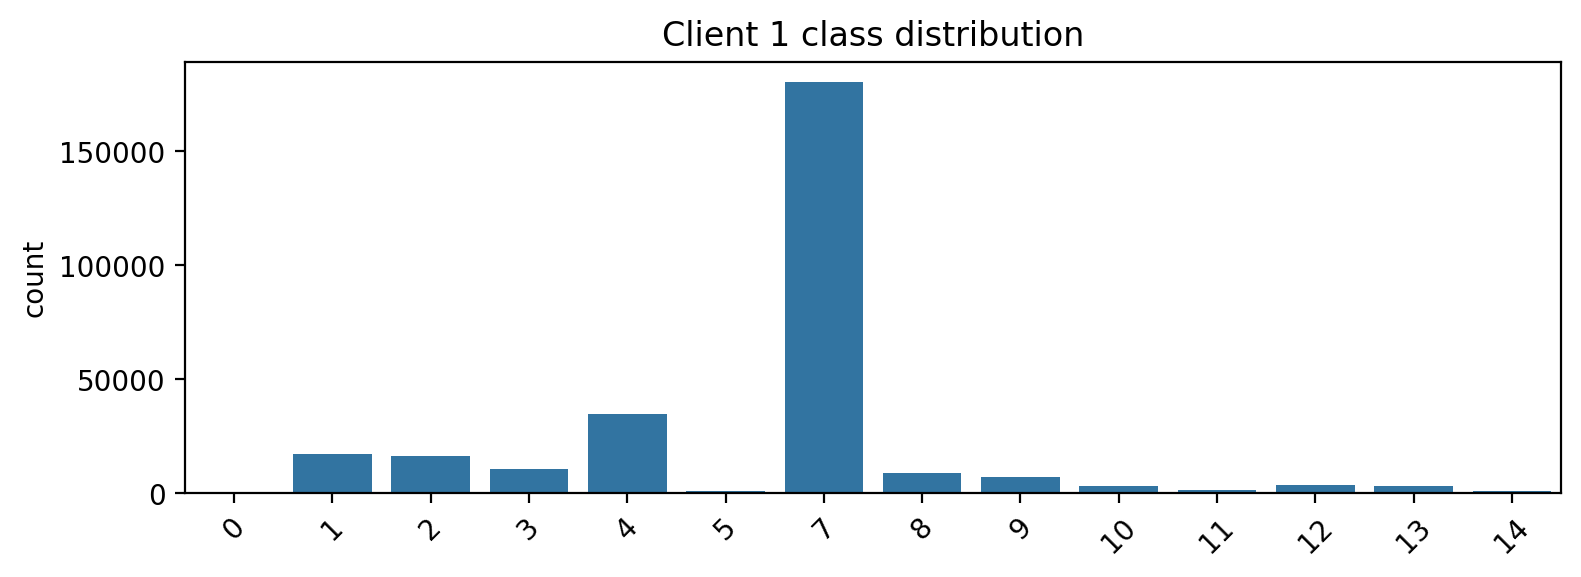

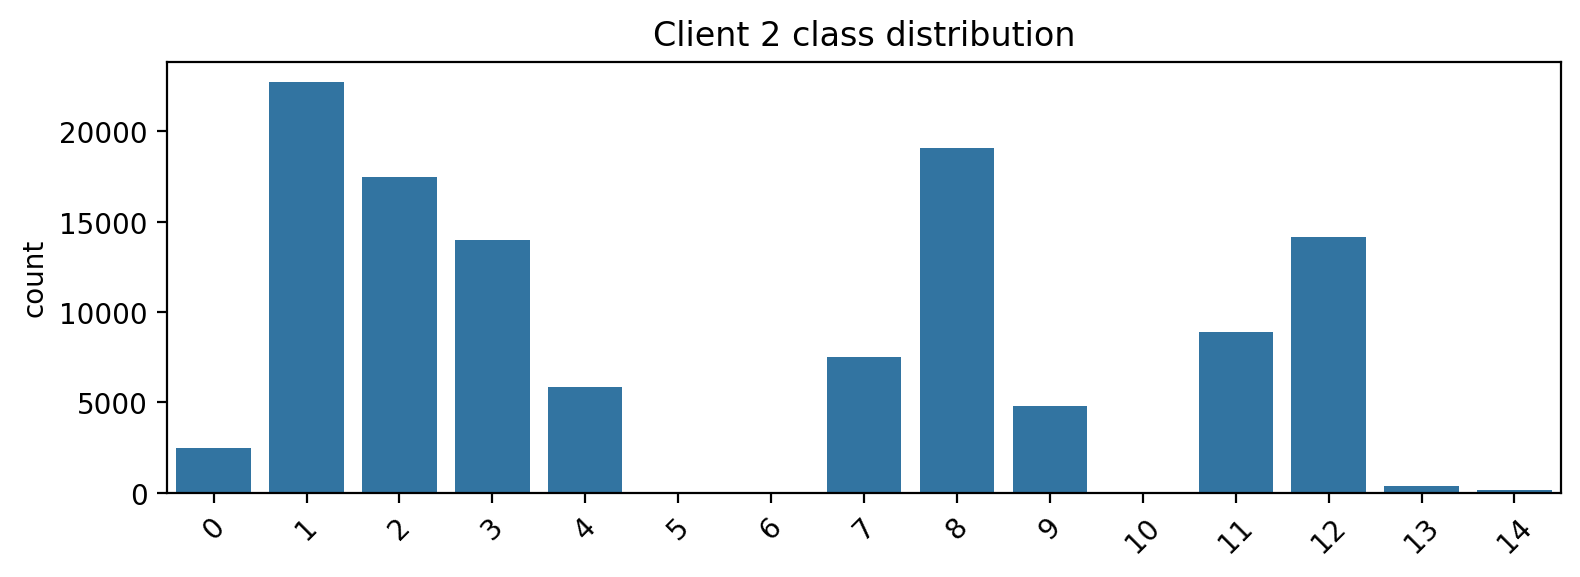

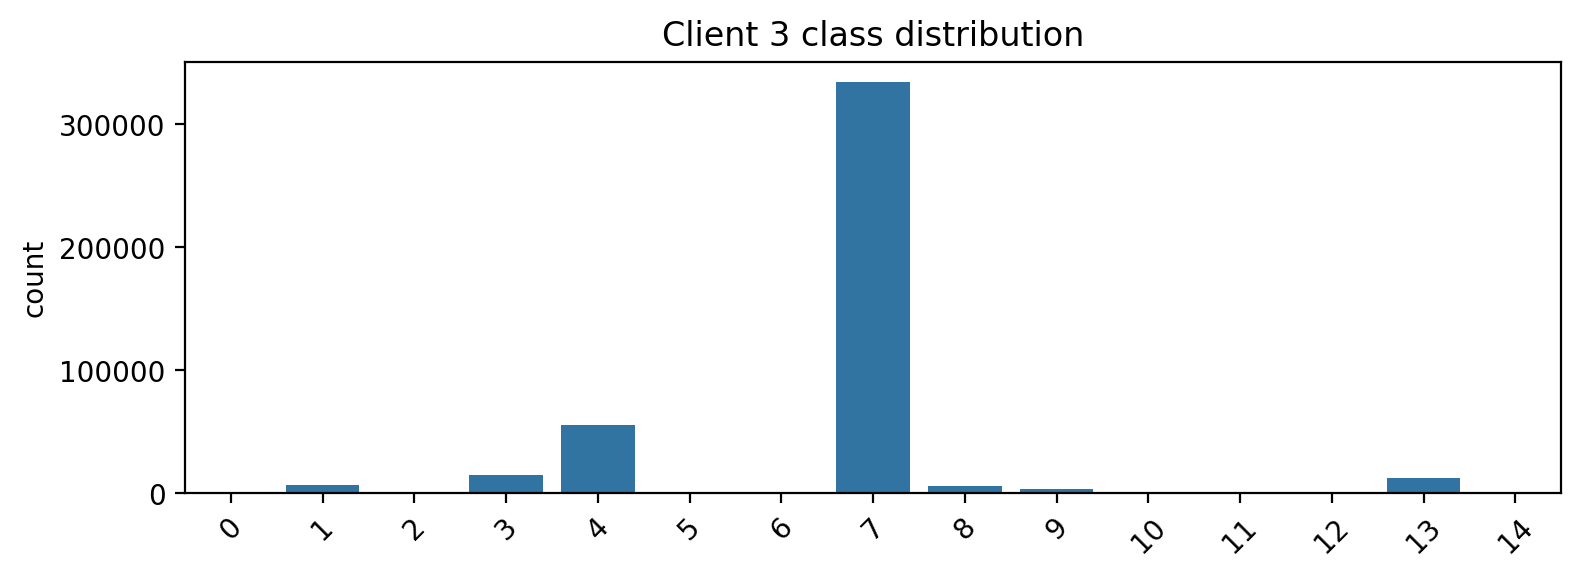

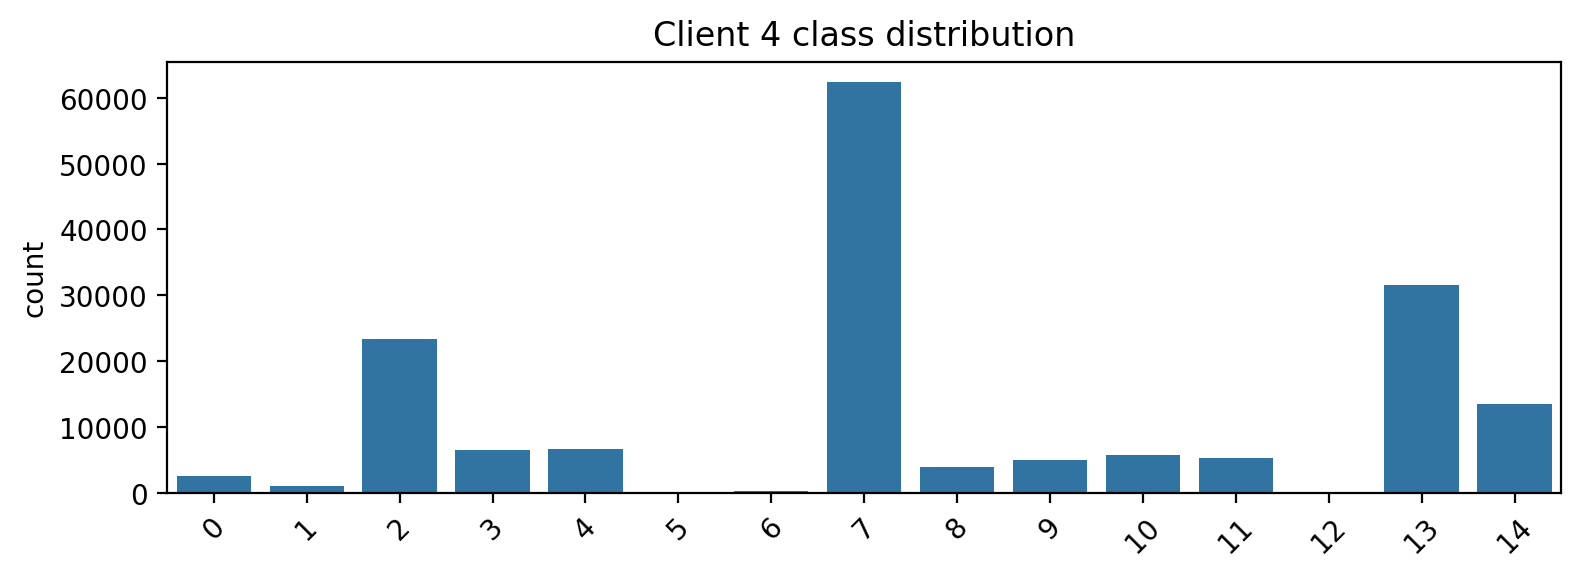

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

for client_id, (_, client_y) in client_datasets.items():
    plt.figure(figsize=(8, 3))
    sns.countplot(x=client_y)
    plt.title(f'Client {client_id} class distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()